# Convolution Neural Network Using TensorFlow

## Processing the data

In [2]:
import gzip as gz
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import random

In [7]:
train_x = gz.open("Data/train-images-idx3-ubyte.gz", "r")
train_y = gz.open("Data/train-labels-idx1-ubyte.gz", "r")

In [8]:
img_size = 28
num_images = 60000

In [9]:
train_x.read(16)  # First 16 bytes contain unecessary information
train_x = train_x.read(img_size * img_size * num_images)
train_x = np.frombuffer(train_x, dtype=np.uint8())
train_x = train_x.reshape(num_images, img_size, img_size)

In [10]:
train_y.read(8)  # First 8 bytes contain unecessary info
train_y = train_y.read(num_images)
train_y = np.frombuffer(train_y, dtype=np.uint8)
train_y = train_y.tolist()

In [11]:
for i in range(len(train_y)):
    index = train_y[i]
    train_y[i] = np.zeros((1, 10), dtype=np.float32)
    np.put(train_y[i], index, 1)

In [12]:
np.save("Data/train_features.npy", train_x)
np.save("Data/train_labels.npy", train_y)

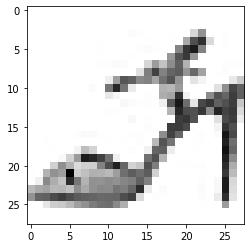

In [6]:
plt.imshow(train_x[np.random.randint(0, len(train_y))], cmap="binary")
plt.show()

## The model

First the data is loaded and converted to tensors.

In [4]:
train_x = np.load("Data/train_features.npy")
train_y = np.load("Data/train_labels.npy")
# c = list(zip(train_x, train_y))
# random.shuffle(c)
# train_x, train_y = zip(*c)
train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
train_x = train_x / 255.0
train_x = train_x[..., tf.newaxis]
train_y = tf.convert_to_tensor(train_y, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(1000).batch(32)

In [5]:
class TrainModel(tf.keras.Model):
    def __init__(self):
        super(TrainModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(8, 3, activation="relu")
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation="relu")
        self.d2 = tf.keras.layers.Dense(32, activation="relu")
        self.d3 = tf.keras.layers.Dense(10, activation="softmax")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

model = TrainModel()

In [21]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
accuracy = tf.keras.metrics.Accuracy()

In [67]:
@tf.function  # This just increases performance
def TrainStep(data_in, data_out):
    with tf.GradientTape() as g:
        preds = model(data_in)
        loss_funct = loss(data_out, preds)
    gradients = g.gradient(loss_funct, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    accuracy(tf.squeeze(data_out), preds)

In [65]:
for img, labels in train_ds:
    TrainStep(img, labels)

In [9]:
# Just messing with tensorflows gradient tape
x = tf.constant(5.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = 2*x**2 + 5*x
dy_dx = g.gradient(y, x)

In [10]:
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=25.0>

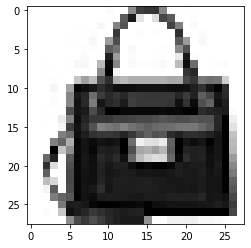

In [73]:
plt.imshow(tf.squeeze(train_x[np.random.randint(0, len(train_y))]), cmap="binary")
plt.show()